# Installation des pré-requis

In [6]:
%pip install plotly
%pip install --upgrade nbformat
%pip install seaborn
%pip install scipy
%pip install tensorflow keras
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import chi2_contingency as chi2_contingency,f_oneway
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,roc_curve
import pickle
%matplotlib inline

# Chargements des données

Chargement des services et statuts

In [3]:
service_df = pd.read_csv('Telco_customer_churn_services.csv')
status_df = pd.read_csv('Telco_customer_churn_status.csv')

**Affichage d'échantillon de service**

In [4]:
service_df.head(2)

,Service ID,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,NaN,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.0,20,0.0,59.65
1,BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.0,0,390.8,1024.10


**Affichage des colonnes de status**

In [5]:
status_df.columns

Index(['Status ID', 'Customer ID', 'Count', 'Quarter', 'Satisfaction Score',
       'Customer Status', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV',
       'Churn Category', 'Churn Reason'],
      dtype='object')

In [6]:
status_df.head(2)

,Status ID,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,SWSORB1252,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,SNAEQA8572,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer


**Jointure afin de centraliser les données**

In [7]:
df=service_df.merge(status_df[['Customer ID','Churn Value','Satisfaction Score','Churn Label','Churn Category']],on='Customer ID',how='left')

**Chargement des informations du client**

In [8]:
demo_df = pd.read_csv('Telco_customer_churn_demographics.csv')

In [9]:
demo_df.head()

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1


**Ajout des informations des clients dans le dataframe**

In [10]:
df=df.merge(demo_df[['Customer ID','Gender','Age','Married','Dependents','Number of Dependents']],on='Customer ID', how='left')

**Affichage d'un échantillon**

In [11]:
df.head()

,Service ID,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Value,Satisfaction Score,Churn Label,Churn Category,Gender,Age,Married,Dependents,Number of Dependents
0,IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,NaN,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,1,3,Yes,Competitor,Male,78,No,No,0
1,BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10,1,3,Yes,Competitor,Female,74,Yes,Yes,1
2,EIMVJQBMT7187,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,1,2,Yes,Competitor,Male,71,No,Yes,3
3,EROZQXDUU4979,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07,1,2,Yes,Dissatisfaction,Female,78,Yes,Yes,1
4,GEEYSJUHY6991,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,1,2,Yes,Price,Female,80,Yes,Yes,1


**Choix des paramètres importants**

In [12]:
df=df[['Service ID','Customer ID','Phone Service','Internet Service','Avg Monthly GB Download','Satisfaction Score','Churn Label','Churn Category','Gender','Age','Married','Dependents','Number of Dependents','Churn Value']]

# Nettoyage de données

**Taille du dataframe**

In [13]:
df.size

98602

**Suppression des doublons et vérification**

In [14]:
df.drop_duplicates(subset=['Service ID'],inplace=True)
df.size

98602

# EDA

**Analyse univariée**

In [15]:
df.shape

(7043, 14)

**Nature des variables**

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Service ID               7043 non-null   object
 1   Customer ID              7043 non-null   object
 2   Phone Service            7043 non-null   object
 3   Internet Service         7043 non-null   object
 4   Avg Monthly GB Download  7043 non-null   int64 
 5   Satisfaction Score       7043 non-null   int64 
 6   Churn Label              7043 non-null   object
 7   Churn Category           1869 non-null   object
 8   Gender                   7043 non-null   object
 9   Age                      7043 non-null   int64 
 10  Married                  7043 non-null   object
 11  Dependents               7043 non-null   object
 12  Number of Dependents     7043 non-null   int64 
 13  Churn Value              7043 non-null   int64 
dtypes: int64(5), object(9)
memory usage: 770

**Distribution & positionnement de la donnée**

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg Monthly GB Download,7043.0,20.515405,20.418940,0.0,3.0,17.0,27.0,85.0
Satisfaction Score,7043.0,3.244924,1.201657,1.0,3.0,3.0,4.0,5.0
Age,7043.0,46.509726,16.750352,19.0,32.0,46.0,60.0,80.0
Number of Dependents,7043.0,0.468692,0.962802,0.0,0.0,0.0,0.0,9.0
Churn Value,7043.0,0.265370,0.441561,0.0,0.0,0.0,1.0,1.0


**Détection des valeurs extrêmes**

In [18]:
px.box(df,y='Avg Monthly GB Download').show()

In [19]:
px.box(df,y='Satisfaction Score')

In [20]:
px.box(df,y='Age').show()

In [21]:
px.box(df,y='Number of Dependents').show()

**Analyse univariée**

*Analyse univariée des genres*

In [22]:
gender_df = df[['Service ID','Gender']].groupby('Gender').count().reset_index()
fig = px.pie(values=gender_df['Service ID'], labels=gender_df['Gender'],names=gender_df['Gender'])
fig.show()

*Analyse univariée des churns*

In [23]:
churn_number = df[['Service ID','Churn Label']].groupby('Churn Label').count().reset_index()
px.pie(values=churn_number['Service ID'],labels=churn_number['Churn Label'],names=churn_number['Churn Label']).show()

*Analyse univariée du statut matrimonial*

In [24]:
married_df = df[['Service ID','Married']].groupby('Married').count().reset_index()
px.pie(values=married_df['Service ID'], labels=married_df['Married'],names=married_df['Married']).show()

*Analyse univariée de la dépendance*

In [25]:
dependents_df = df[['Service ID','Dependents']].groupby('Dependents').count().reset_index()
px.pie(values=dependents_df['Service ID'], labels=dependents_df['Dependents'],names=dependents_df['Dependents']).show()

*Analyse univariée de l'abonnement au service téléphonique*

In [26]:
phone_df=df[['Service ID','Phone Service']].groupby('Phone Service').count().reset_index()
px.pie(values=phone_df['Service ID'], labels=phone_df['Phone Service'],names=phone_df['Phone Service'])

*Analyse univariée de l'abonnement au service internet*

In [27]:
internet_df=df[['Service ID','Internet Service']].groupby('Internet Service').count().reset_index()
px.pie(values=internet_df['Service ID'], labels=internet_df['Internet Service'],names=internet_df['Internet Service']).show()

**Corrélations**

*Corrélations entre variables numériques*

<Axes: >

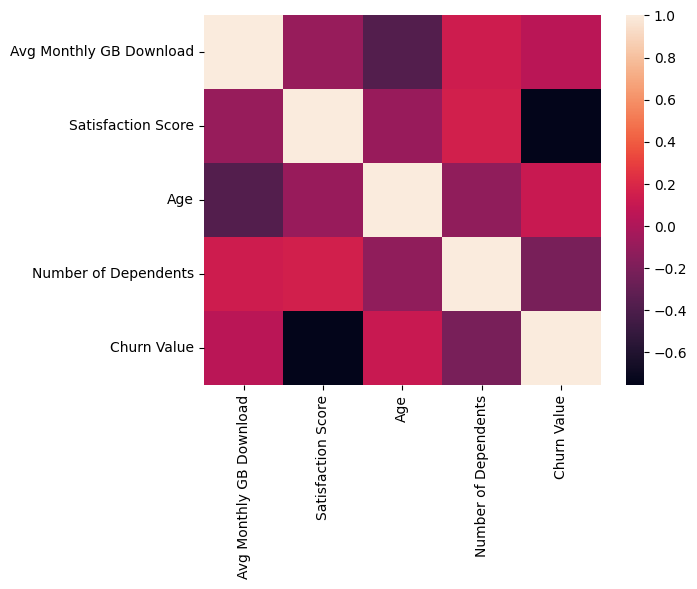

In [28]:
sns.heatmap(df.corr(numeric_only=True),xticklabels=True)

**Corrélation entre variables catégorielles**

*Corrélation entre le Churn et l'abonnement au service téléphonique*

In [29]:
khi2, pval , ddl , contingent_theorique = chi2_contingency(pd.crosstab(df['Phone Service'],df['Churn Label']))
print("L'abonnement au service téléphonique est corrélé au désabonnement" if pval<=0.5 else "L'abonnement au service téléphonique n'est pas corrélé au désabonnement")

L'abonnement au service téléphonique est corrélé au désabonnement


*Corrélation entre le Churn et l'abonnement au service internet*

In [30]:
khi2, pval , ddl , contingent_theorique = chi2_contingency(pd.crosstab(df['Internet Service'],df['Churn Label']))
print("L'abonnement au service internet est corrélé au désabonnement" if pval<=0.5 else "L'abonnement au service internet n'est pas corrélé au désabonnement")

L'abonnement au service internet est corrélé au désabonnement


*Corrélation entre le churn et le statut matrimonial*

In [31]:
khi2, pval , ddl , contingent_theorique = chi2_contingency(pd.crosstab(df['Married'],df['Churn Label']))
print("Le statut matrimonial est corrélé au désabonnement" if pval<=0.5 else "Le statut matrimonial n'est pas corrélé au désabonnement")

Le statut matrimonial est corrélé au désabonnement


**Corrélation entre variables catégorielles et numériques**

*Corrélation entre la consommation moyenne de connexion et le churn*

In [32]:
df_group=[df['Avg Monthly GB Download'][df['Churn Label'] == groupe] for groupe in df['Churn Label'].unique()]
f_stat, p_value = f_oneway(*df_group)
print("Il n'a pas de corrélation entre la moyenne de téléchargement par mois et le churn" if p_value<0.05 else "Il existe une corrélation entre la moyenne de téléchargement par mois et le churn")

Il n'a pas de corrélation entre la moyenne de téléchargement par mois et le churn


*Corrélation entre le score de satisfaction et le churn*

In [33]:
group_df=[df['Satisfaction Score'][df['Churn Label'] == groupe] for groupe in df['Churn Label'].unique()]
f_stat, p_value = f_oneway(*group_df)
print("Il n'a pas de corrélation entre le score de satisfaction et le churn" if p_value<0.05 else "Il existe une corrélation entre le score de satisfaction  et le churn")

Il n'a pas de corrélation entre le score de satisfaction et le churn


*Corrélation entre l'âge et le churn*

In [34]:
group_df=[df['Age'][df['Churn Label'] == groupe] for groupe in df['Churn Label'].unique()]
f_stat, p_value = f_oneway(*group_df)
print("Il n'y a pas de corrélation entre l'âge et le churn" if p_value<0.05 else "Il y a une corrélation entre l'âge et le churn")

Il n'y a pas de corrélation entre l'âge et le churn


*Corrélation entre le nombre de personnes à charge et le churn*

In [35]:
group_df=[df['Number of Dependents'][df['Churn Label'] == groupe] for groupe in df['Churn Label'].unique()]
f_stat, p_value = f_oneway(*group_df)
print("Il n'y a pas de corrélation entre le nombre de personne à charge et le churn" if p_value<0.05 else "Il y a une corrélation entre le nombre de personne à charge et le churn")

Il n'y a pas de corrélation entre le nombre de personne à charge et le churn



# Annotation des variables

In [36]:
df['Gender_Value']= [1 if gender == "Male" else 0 for gender in df['Gender']]

In [37]:
df['Phone Service_Value'] = [1 if service == "Yes" else 0 for service in df['Phone Service']]

In [38]:
df['Married_Value']=[1 if married == "Yes" else 0 for married in df["Married"]]
df['Internet Service_Value'] = [1 if internet == "Yes" else 0 for internet in df['Internet Service']]

In [39]:
df_training = df[['Phone Service_Value','Gender_Value','Married_Value','Satisfaction Score','Avg Monthly GB Download','Internet Service_Value','Churn Value']]

In [40]:
df_training.head()

,Phone Service_Value,Gender_Value,Married_Value,Satisfaction Score,Avg Monthly GB Download,Internet Service_Value,Churn Value
0,0,1,0,3,8,1,1
1,1,0,1,3,17,1,1
2,1,1,0,2,52,1,1
3,1,0,1,2,12,1,1
4,1,0,1,2,14,1,1


# Train Test split

In [41]:
df_training[1:]

,Phone Service_Value,Gender_Value,Married_Value,Satisfaction Score,Avg Monthly GB Download,Internet Service_Value,Churn Value
1,1,0,1,3,17,1,1
2,1,1,0,2,52,1,1
3,1,0,1,2,12,1,1
4,1,0,1,2,14,1,1
5,1,0,0,1,18,1,1
...,...,...,...,...,...,...,...
7038,1,0,0,5,0,0,0
7039,1,1,1,3,24,1,0
7040,1,0,1,4,59,1,0
7041,0,0,1,4,17,1,0


In [63]:
x_train,x_test,y_train,y_test = train_test_split(df_training.drop('Churn Value',axis=1), df_training['Churn Value'],test_size=0.4,random_state=42)

# Construction du modèle

**Sélection des modèles de classification**

In [148]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(),
    SVC(),
    GaussianProcessClassifier(kernel=1.0*RBF(1.0),random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
parameters= [
    None,
    {'svc__C':[0.025,1.0],'svc__kernel':["linear"],"svc__random_state":[42]},
    {'svc__C':[0.025,1.0],'svc__gamma':[2],"svc__random_state":[42]},
    None,
    {'decisiontreeclassifier__max_depth':[1,2,5],'decisiontreeclassifier__criterion':['gini','entropy'],'decisiontreeclassifier__random_state':[42]},
    {'randomforestclassifier__max_depth':[1,2],'randomforestclassifier__max_features':[1,2,5],'randomforestclassifier__random_state':[42],'randomforestclassifier__max_features':[1]},
    None,
    None,
    None,
    None
]
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]


**Entraînement des modèles selectionnés**

In [149]:
models=pd.DataFrame(columns=["name","f1_score","score","model"])
for name,clf, parameter in zip(names,classifiers, parameters):
    clf = make_pipeline(StandardScaler(),clf)
    if parameter is not None:
        clf=GridSearchCV(clf,parameter,cv=5,scoring='f1')
    clf.fit(x_train,y_train)
    if parameter is not None:
        clf=clf.best_estimator_    
    y_pred=clf.predict(x_test)
    models=pd.concat([models,
                      pd.DataFrame({"name":name,
                                    "f1_score":[f1_score(y_test,y_pred)],
                                    'score':[np.mean(cross_val_score(clf,x_test,y_test,cv=5))],
                                    'model': [clf]
                                    })] ,ignore_index=True)

/var/folders/wg/bvw8tv0s2hqdp6rjqb_0l11m0000gn/T/ipykernel_13259/23529141.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



**Choix du meilleur modèle**

In [150]:
models.sort_values(by=['f1_score','score'],ascending=False,inplace=True)
best_model = models.head(1).values[0][-1]

In [151]:
px.bar(data_frame=models,x="name",y="f1_score",color="score")

In [152]:
y_pred=best_model.predict(x_test)
print(f"La précision du modèle : {round(accuracy_score(y_test,y_pred),2)*100}%")

La précision du modèle : 93.0%


<Axes: >

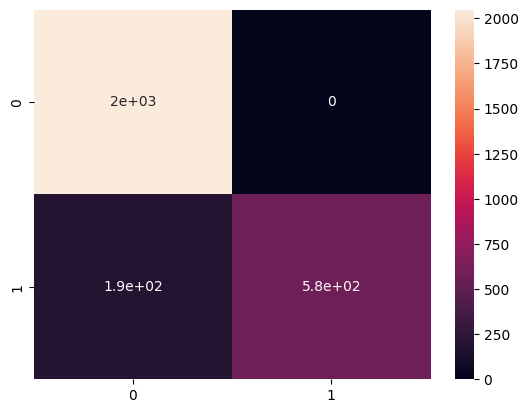

In [153]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [158]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred, pos_label=1)
px.line(x=fpr1,y=tpr1,title="ROC Curve")

In [159]:
with open('churn_model.pkl','wb') as f:
    pickle.dump(best_model,f)

Recommandation bien qu'on est une précision de 93% on se rend compte que le modèle aura tendance à prédire moins de churn ce qui est dû à la qualité désiquilibrée des données d'entraînement. D'où la nécessité d'avoir des données mieux réparties pour la généralisation du modèle